In [1]:
import classy
import numpy as np
import src.mycosmo as mc
import itertools as it
from pathlib import Path
from matplotlib import pyplot as plt
import copy

In [2]:
PROJECT_NAME = "bad_samples"

CWD = Path.cwd()
PROJECT_DIR = CWD / 'output' / PROJECT_NAME / ''
(PROJECT_DIR / "").mkdir(exist_ok=True, parents=True)

PLOT_PATH = PROJECT_DIR / 'plots/'
PLOT_PATH.mkdir(exist_ok=True, parents=True)

DATA_PATH = PROJECT_DIR / 'data/'
DATA_PATH.mkdir(exist_ok=True, parents=True)

In [3]:
lcdm_params = ('h', 'omega_b', 'omega_cdm', 'z_reio', 'n_s', 'ln10^{10}A_s')

range_of_lcdm_param = {'h': (0.6, 0.8),
                       "ln10^{10}A_s": (2.9, 3.1),
                       'omega_cdm': (0.11, 0.15),
                       'omega_b': (0.02, 0.026),
                       'n_s': (0.92, 1.0),
                       'z_reio': (6, 11),
                       }

lcdm_dim_of_params = dict(zip(lcdm_params, it.repeat(1)))

In [4]:
# %% initialized gdm sampled parameters

gdm_log10a_era_interval_vals = (-14.0, -7.0, -5.0, np.log10(1/501.0), 0.0)
gdm_log10a_era_interval_dims = (1, 4, 8, 1)  # the number of knots in an interval the end point is not included

gdm_log10a_intervals = []
for interval_start, interval_end, interval_dims in zip(gdm_log10a_era_interval_vals,
                                                       gdm_log10a_era_interval_vals[1:],
                                                       gdm_log10a_era_interval_dims):
    # log10a vals for the knots in the interval, interval_dim-1 accounts for interval end being start of next interval
    gdm_log10a_intervals += [np.linspace(interval_start, interval_end, interval_dims, endpoint=False)]

# add last endpoint
gdm_log10a_intervals += [np.array([gdm_log10a_era_interval_vals[-1]])]
gdm_knots_log10a = np.concatenate(gdm_log10a_intervals)

gdm_n_knots = len(gdm_knots_log10a)

z_alpha = 3000.
a_alpha = 1 / (1 + z_alpha)
alpha_gdm = 0.10
c_s2 = 1
c_vis2 = 0

gdm_vals_of_fixed_param = {'gdm_log10a_vals': gdm_knots_log10a,
                           'gdm_c_eff2': c_s2,
                           'nap': 'y',
                           'gdm_c_vis2': c_vis2,
                           'gdm_interpolation_order': 1,
                           'gdm_z_alpha': z_alpha
                           }

gdm_params = ('gdm_alpha', 'gdm_w_vals')
gdm_dims_of_params = dict(zip(gdm_params, (1, gdm_n_knots)))

gdm_alpha_range = (0.0, 0.2)
gdm_w_range = (np.array([-1.0]*(gdm_n_knots-gdm_log10a_era_interval_dims[-1])
                        +[1.0/3.0]*gdm_log10a_era_interval_dims[-1]),
               np.array([-1.0/3.0] * gdm_log10a_era_interval_dims[0]
                        + [1.0] * (gdm_n_knots - gdm_log10a_era_interval_dims[0])),
               )


def is_in_w_range(w_vals):
    return np.all(w_vals-gdm_w_range[0] >= 0) and np.all(gdm_w_range[1]-w_vals >= 0)


gdm_classy_params = ('gdm_alpha', 'gdm_w_vals') + tuple(gdm_vals_of_fixed_param.keys())

model_dim_of_params = {**lcdm_dim_of_params,**gdm_dims_of_params}
n_dim_sampled = sum(model_dim_of_params.values())

mp = mc.ModelParameters(model_dim_of_params,
                        vals_of_fixed_params=gdm_vals_of_fixed_param,
                        class_input_params=lcdm_params + gdm_classy_params)


In [5]:

gdm_mu_w = np.array([0] * gdm_n_knots)

dij = np.array([[np.abs(log10a1 - log10a2) for log10a1 in gdm_knots_log10a] for log10a2 in gdm_knots_log10a])

rho = 0.1
sigma = 0.75

dij_over_rho = dij / rho
Cij = (sigma ** 2 * np.exp(-dij_over_rho * dij_over_rho))

rng_def = np.random.default_rng()

def make_sample_params(rng=rng_def):
    lcdm_sample = np.array(
        [rng.uniform(*range_of_lcdm_param[param]) for param in lcdm_params])
    gmd_alpha_sample = np.array([rng.uniform(*gdm_alpha_range)])

    w_vals_sample = rng.multivariate_normal(gdm_mu_w, Cij)
    while not is_in_w_range(w_vals_sample):
        w_vals_sample = rng.multivariate_normal(gdm_mu_w, Cij)

    return np.concatenate((lcdm_sample, gmd_alpha_sample, w_vals_sample))



In [6]:
output_settings_DEF = {'output': 'tCl,pCl,lCl',
                               'lensing': 'yes',
                               'l_max_scalars': 5000}
l_max = 2700
l_min = 2

def make_sample_cls(cosmo:classy.Class,
                    sample_param_vals,
                    modelparams=mp,
                    output_setting=None):
    if output_setting is None:
        output_setting = output_settings_DEF
    cosmo.set({**modelparams.get_class_input(sample_param_vals),
               **output_setting})
    cosmo.compute()
    cls = cosmo.lensed_cl()
    lensed_cls = np.vstack(tuple(cls[k][l_min:l_max+1].astype(float) for k in ['tt', 'te', 'ee']))

    cosmo.struct_cleanup()
    cosmo.empty()

    return lensed_cls



In [7]:

def make_bad_samples(n_total=10):

    rng = np.random.default_rng(1000)

    bad_sampled_params = np.empty((n_total, n_dim_sampled))
    bad_sample_cls = np.empty((n_total, 3, l_max - l_min + 1))

    cosmo = classy.Class()
    n_bad_samples = 0
    attempt_count = 0
    while n_bad_samples < n_total and attempt_count < 100 * n_total:
        sample_param_vals = make_sample_params(rng=rng)
        try:
            bad_sample_cls[n_bad_samples, :] = make_sample_cls(cosmo, sample_param_vals)
            if  np.any(bad_sample_cls[n_bad_samples, 0,:] < 0) or  np.any(bad_sample_cls[n_bad_samples, 2, :] < 0):
               bad_sampled_params[n_bad_samples, :] = sample_param_vals
               n_bad_samples += 1
            attempt_count += 1
        except classy.CosmoComputationError:
            attempt_count += 1

    assert n_bad_samples==n_total, "Bad samples at rate < 0.01"

    return bad_sampled_params, bad_sample_cls

In [8]:
bad_params, bad_cls = make_bad_samples(n_total=1)

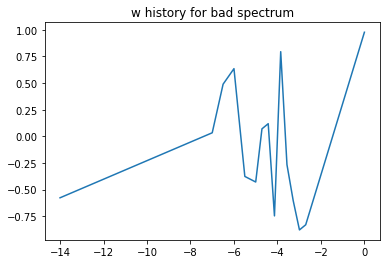

In [9]:
mp.get_vals_of_model_params(bad_params[0])
bad_w_vals = mp.get_vals_of_model_params(bad_params[0])['gdm_w_vals']

plt.plot(gdm_knots_log10a, bad_w_vals);
plt.title("w history for bad spectrum");


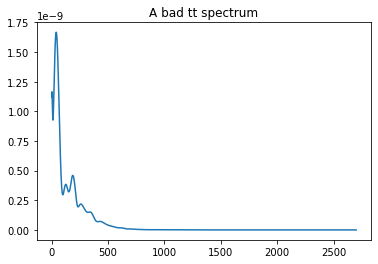

In [10]:
mp.get_vals_of_model_params(bad_params[0])

ells = np.arange(2,2700+1)
ell_factor = ells*(ells+1)/2/np.pi
plt.plot(ells, ell_factor*bad_cls[0,0,:]);
plt.title("A bad tt spectrum");

In [11]:
cosmo = classy.Class()
planck18_param = (0.67810, 0.02238280, 0.1201075, 7.6711, 0.9660499, 3.04478383) +(1+gdm_n_knots)*(0,)
plank18_cls = make_sample_cls(cosmo,planck18_param)
a_sample_param = make_sample_params()
a_cl_sample = make_sample_cls(cosmo,a_sample_param)

In [33]:
a_sample_param[-16]

0.1011900849607256

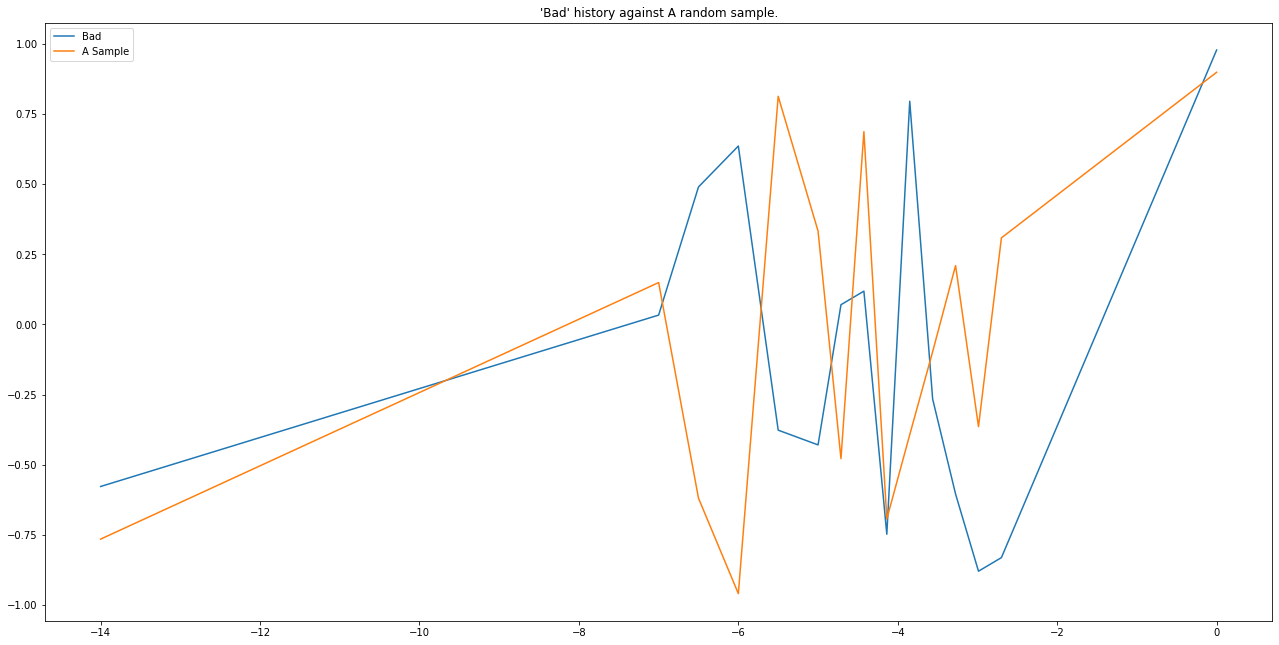

In [49]:
mp.get_vals_of_model_params(bad_params[0])
bad_w_vals = mp.get_vals_of_model_params(bad_params[0])['gdm_w_vals']
a_sample_w_vals = mp.get_vals_of_model_params(a_sample_param)['gdm_w_vals']

fig, axs = plt.subplots(1, sharex=True, figsize=(22, 11))
plt.plot(gdm_knots_log10a, bad_w_vals);
plt.plot(gdm_knots_log10a, a_sample_w_vals);
plt.legend(['Bad','A Sample'])
plt.title("'Bad' history against A random sample.");


In [14]:
modes_names = ['TT','TE','EE']

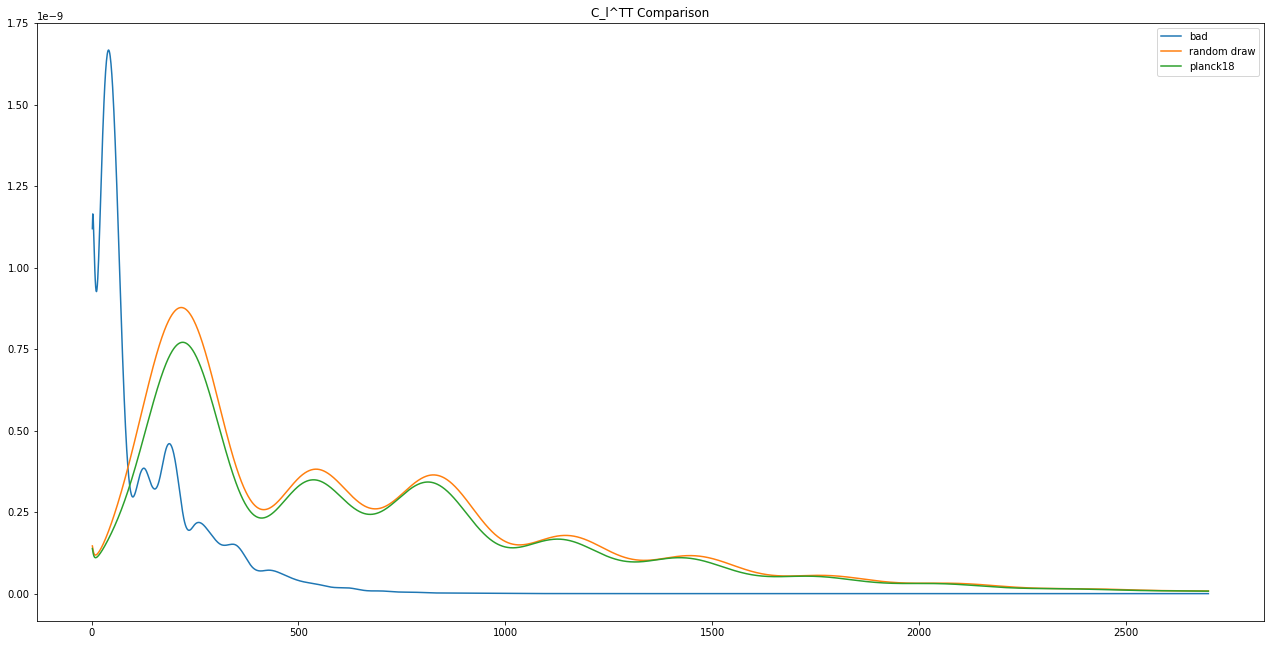

In [50]:
mode = 0
fig, axs = plt.subplots(1, sharex=True, figsize=(22, 11))
ells = np.arange(2,2700+1)
ell_factor = ells*(ells+1)/2/np.pi
plt.plot(ells, ell_factor*bad_cls[0,mode,:],label="bad");
plt.plot(ells, ell_factor*a_cl_sample[mode,:],label="random draw");
plt.plot(ells, ell_factor*plank18_cls[mode,:], label="planck18");
plt.legend()
plt.title("C_l^" +modes_names[mode]+ " Comparison");

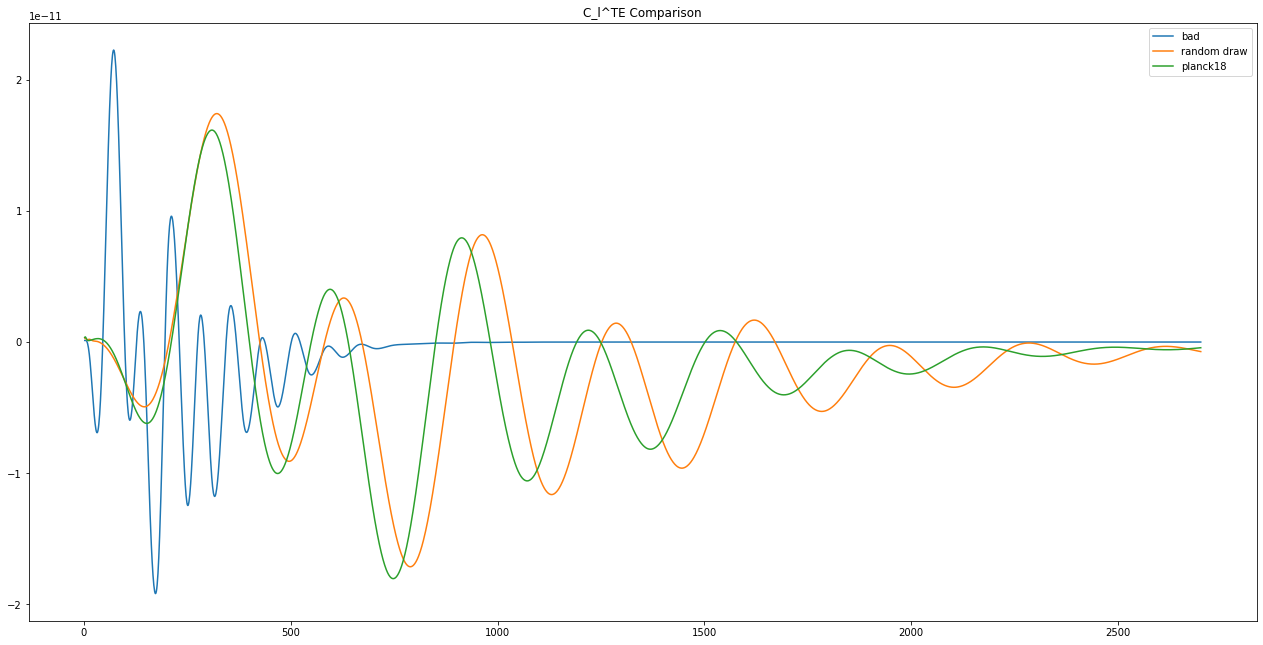

In [38]:
mode = 1
fig, axs = plt.subplots(1, sharex=True, figsize=(22, 11))
ells = np.arange(2,2700+1)
ell_factor = ells*(ells+1)/2/np.pi
plt.plot(ells, ell_factor*bad_cls[0,mode,:],label="bad");
plt.plot(ells, ell_factor*a_cl_sample[mode,:],label="random draw");
plt.plot(ells, ell_factor*plank18_cls[mode,:], label="planck18");
plt.legend()
plt.title("C_l^" +modes_names[mode]+ " Comparison");

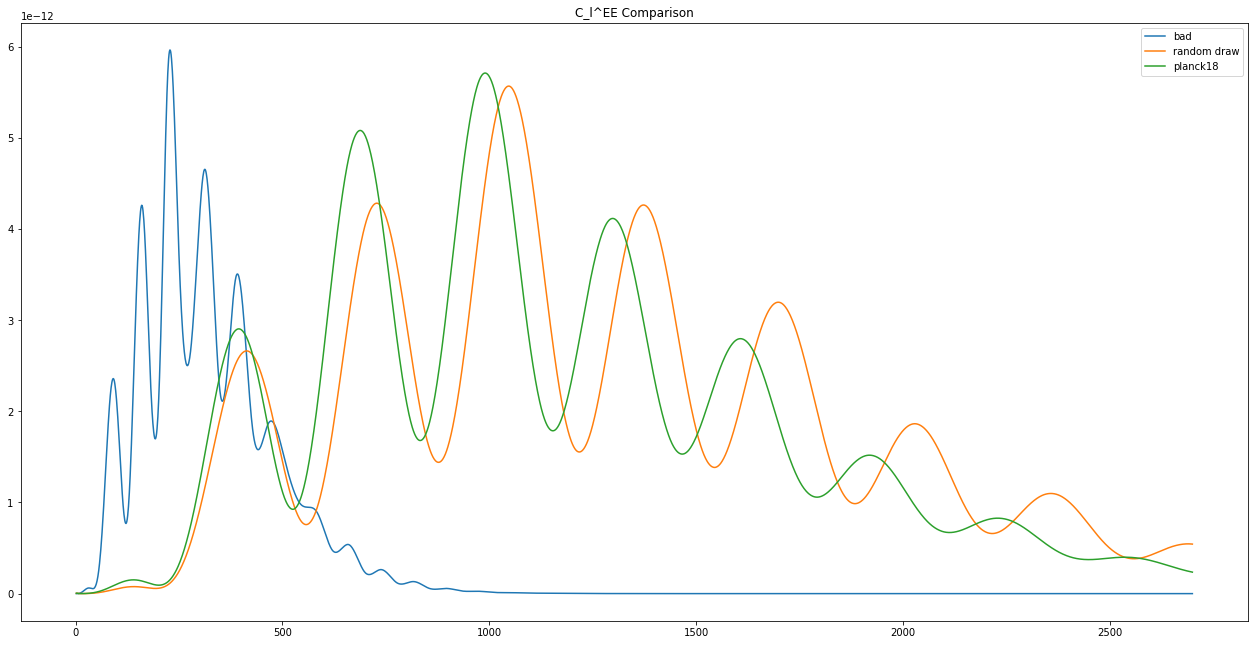

In [39]:
mode = 2
fig, axs = plt.subplots(1, sharex=True, figsize=(22, 11))
ells = np.arange(2,2700+1)
ell_factor = ells*(ells+1)/2/np.pi
plt.plot(ells, ell_factor*bad_cls[0,mode,:],label="bad");
plt.plot(ells, ell_factor*a_cl_sample[mode,:],label="random draw");
plt.plot(ells, ell_factor*plank18_cls[mode,:], label="planck18");
plt.legend()
plt.title("C_l^" +modes_names[mode]+ " Comparison");

In [52]:
mp.get_vals_of_model_params(bad_params[0])

{'gdm_log10a_vals': array([-14.        ,  -7.        ,  -6.5       ,  -6.        ,
         -5.5       ,  -5.        ,  -4.71247972,  -4.42495943,
         -4.13743915,  -3.84991886,  -3.56239858,  -3.27487829,
         -2.98735801,  -2.69983773,   0.        ]),
 'gdm_c_eff2': 1,
 'nap': 'y',
 'gdm_c_vis2': 0,
 'gdm_interpolation_order': 1,
 'gdm_z_alpha': 3000.0,
 'h': array([0.70742616]),
 'omega_b': array([0.02540983]),
 'omega_cdm': array([0.13545016]),
 'z_reio': array([8.2888592]),
 'n_s': array([0.97972074]),
 'ln10^{10}A_s': array([2.92418486]),
 'gdm_alpha': array([0.13732549]),
 'gdm_w_vals': array([-0.57731581,  0.03325118,  0.48972136,  0.6355456 , -0.37662767,
        -0.42915511,  0.07022911,  0.11859582, -0.74736033,  0.79507033,
        -0.26581744, -0.60421951, -0.87908199, -0.83069965,  0.97757946])}

In [18]:
low_alpha_bad_params = copy.copy(bad_params[0])
low_alpha_bad_params[-16] = 0.01
low_alpha_cl_sample = make_sample_cls(cosmo,low_alpha_bad_params)

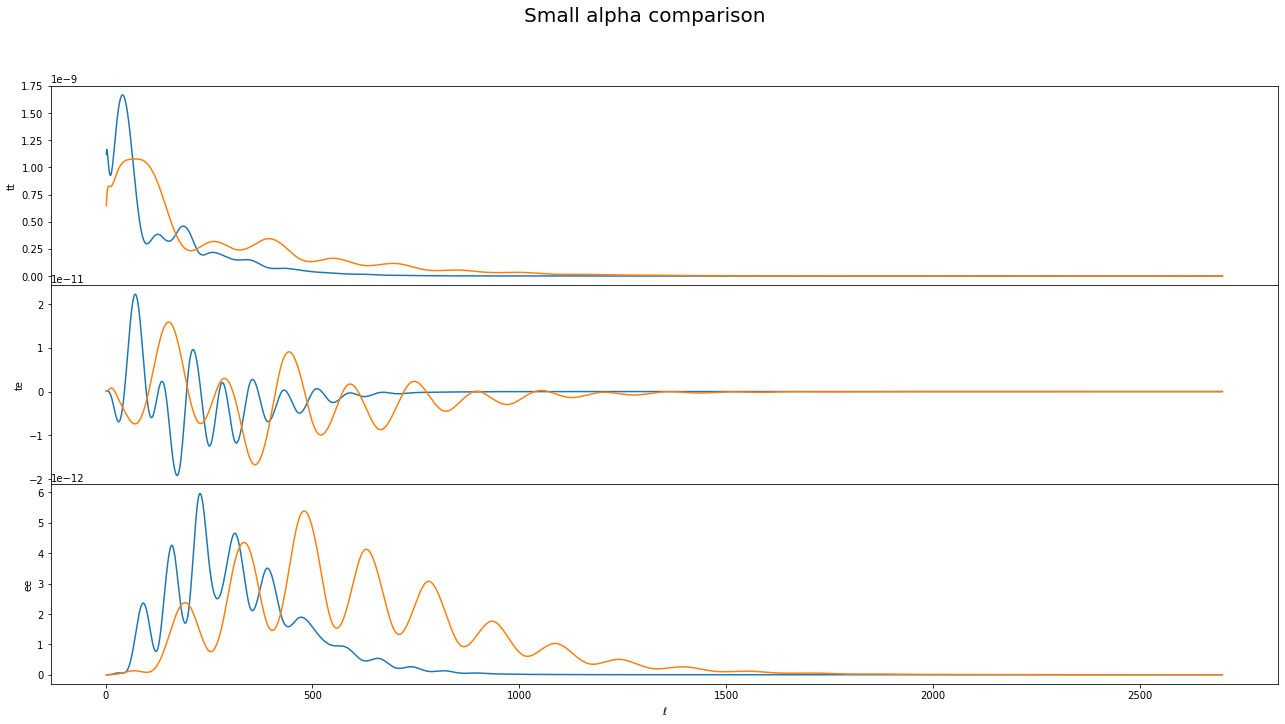

In [19]:
fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
fig.subplots_adjust(hspace=0)
fig.suptitle('Small alpha comparison',  fontsize=20)
plt.autoscale(

)
plt.xlabel(r'$\ell$')
for mode_idx, mode in enumerate(['tt','te','ee']):
    axs[mode_idx].plot(ells, ell_factor*bad_cls[0,mode_idx,:],label = mode)
    axs[mode_idx].plot(ells, ell_factor*low_alpha_cl_sample[mode_idx,:],label = mode)
    axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
plt.show()



In [20]:
low_alpha_bad_params = copy.copy(bad_params[0])
alpha_range = np.linspace(low_alpha_bad_params[-16], 0 , 6)
alpha_range_cls = []
for idx,alpha in enumerate(alpha_range):
    low_alpha_bad_params[-16] = alpha
    alpha_range_cls += [make_sample_cls(cosmo,low_alpha_bad_params)]



In [21]:
# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# line, = ax.plot([])   

# mode_idx = 0
# ax.set_xlim(2,2600)
# ax.set_ylim(-1e-10,1.5e-9)

# def animate(frame_num):
#     line.set_data((ells, ell_factor*alpha_range_cls[frame_num][mode_idx,:]))
#     return line

# anim = animation.FuncAnimation(fig, animate, frames=10, interval=200,repeat=True)
# plt.show()

# display

# # make a generator 
# def get_frame():
#     for fr in frames:
#         yield fr


# # make the function to pass to FuncAnimation method
# def draw_next_frame(n):
#     G = next(get_frame)  # here your call the next graph in the list
#     plt.cla()
#     plt.title('frame {}'.format(n))  # each graph is a new frame
#     pos = nx.spring_layout(G, iterations=200)
#     nx.draw(G, pos, node_color=range(len(G.nodes)), node_size=100)

# ani = animation.FuncAnimation(plt.gcf(), draw_next_frame, 50)
# ani.save('alpha_transition.gif', writer='Pillow')

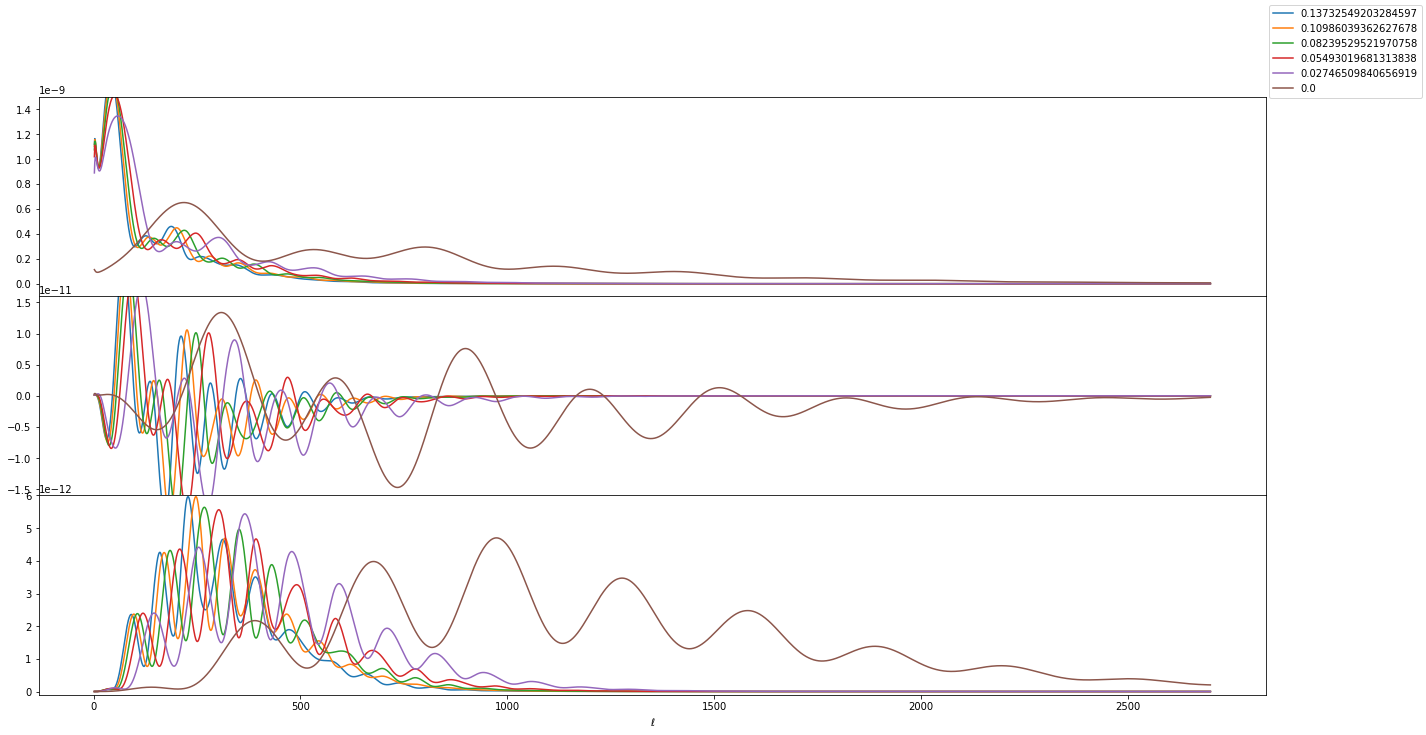

In [22]:
fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11));
fig.subplots_adjust(hspace=0);
plt.xlabel(r'$\ell$')
for cls, alpha in zip(alpha_range_cls,alpha_range):
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*cls[mode_idx,:],label = alpha);
        axs[mode_idx].set_ylim(((-1e-10,1.5e-9),(-1.6e-11,1.6e-11),(-1e-13,6e-12))[mode_idx])
    
fig.legend(alpha_range);

In [23]:
copy_a_sample_params = copy.copy(a_sample_param)
alpha_a_sample_range = np.linspace(a_sample_param[-16], 0 , 6)
alpha_a_sample_range_cls = []
for idx,alpha in enumerate(alpha_a_sample_range):
    copy_a_sample_params[-16] = alpha
    alpha_a_sample_range_cls += [make_sample_cls(cosmo,copy_a_sample_params)]


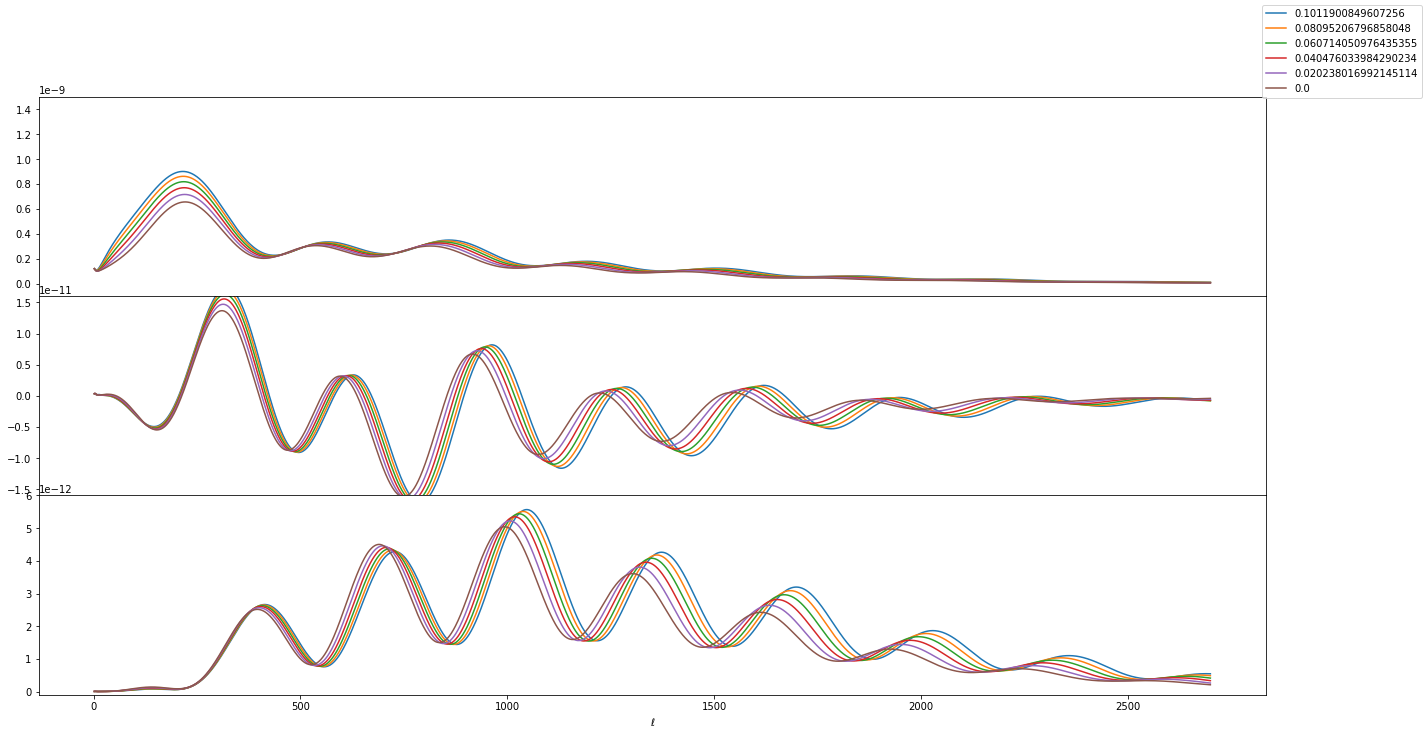

In [24]:
fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11));
fig.subplots_adjust(hspace=0);
plt.xlabel(r'$\ell$')
for cls, alpha in zip(alpha_a_sample_range_cls,alpha_a_sample_range):
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*cls[mode_idx,:],label = alpha);
        axs[mode_idx].set_ylim(((-1e-10,1.5e-9),(-1.6e-11,1.6e-11),(-1e-13,6e-12))[mode_idx])
    
fig.legend(alpha_a_sample_range);

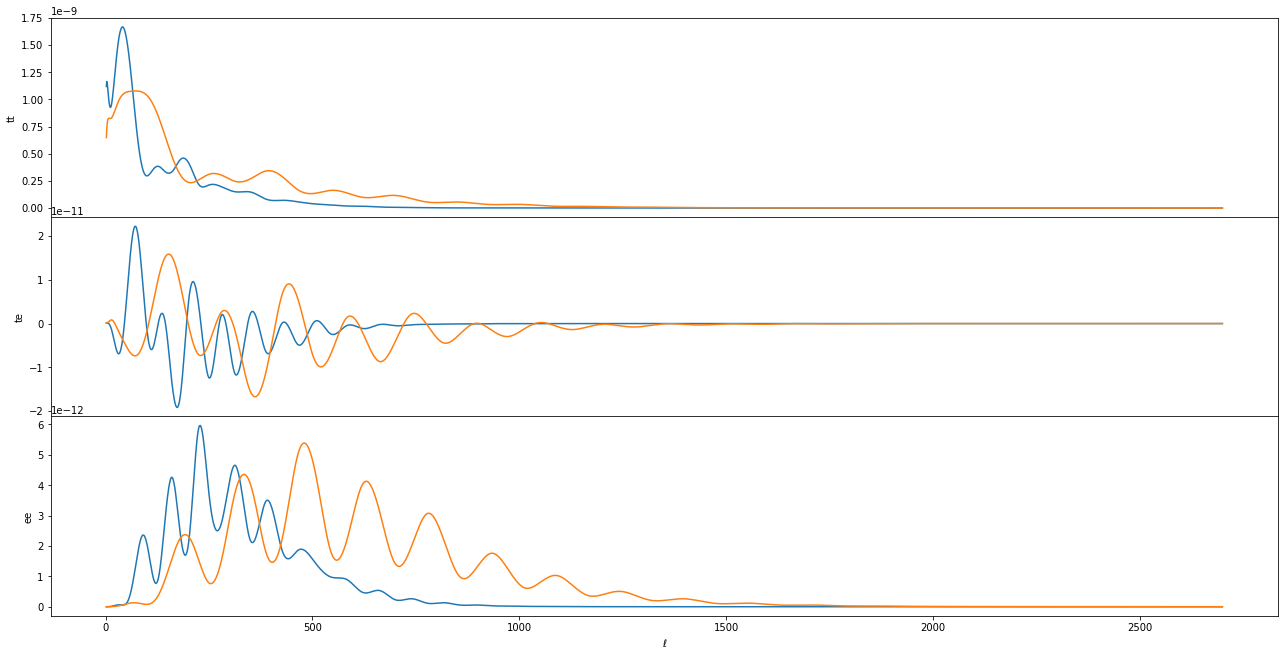

In [25]:
fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
fig.subplots_adjust(hspace=0)
plt.autoscale()
plt.xlabel(r'$\ell$')
for mode_idx, mode in enumerate(['tt','te','ee']):
    axs[mode_idx].plot(ells, ell_factor*bad_cls[0,mode_idx,:],label = mode)
    axs[mode_idx].plot(ells, ell_factor*low_alpha_cl_sample[mode_idx,:],label = mode)
    axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
plt.show()



In [26]:
precision_options = (('tol_perturbations_integration',1e-5),
                     ('perturbations_integration_stepsize',0.5),
                     ('tol_background_integration',1e-10),
                     ('perturbations_sampling_stepsize',0.1)
                    )

prec_cls = {}

for pre_key, def_val in precision_options:
    cosmo.set({**mp.get_class_input(bad_params[0]),
               **output_settings_DEF,
              pre_key:def_val/2.0})
    cosmo.compute()
    cls = cosmo.lensed_cl()
    prec_cls[pre_key] = np.vstack(tuple(cls[k][l_min:l_max+1].astype(float) for k in ['tt', 'te', 'ee']))

    cosmo.struct_cleanup()
    cosmo.empty()

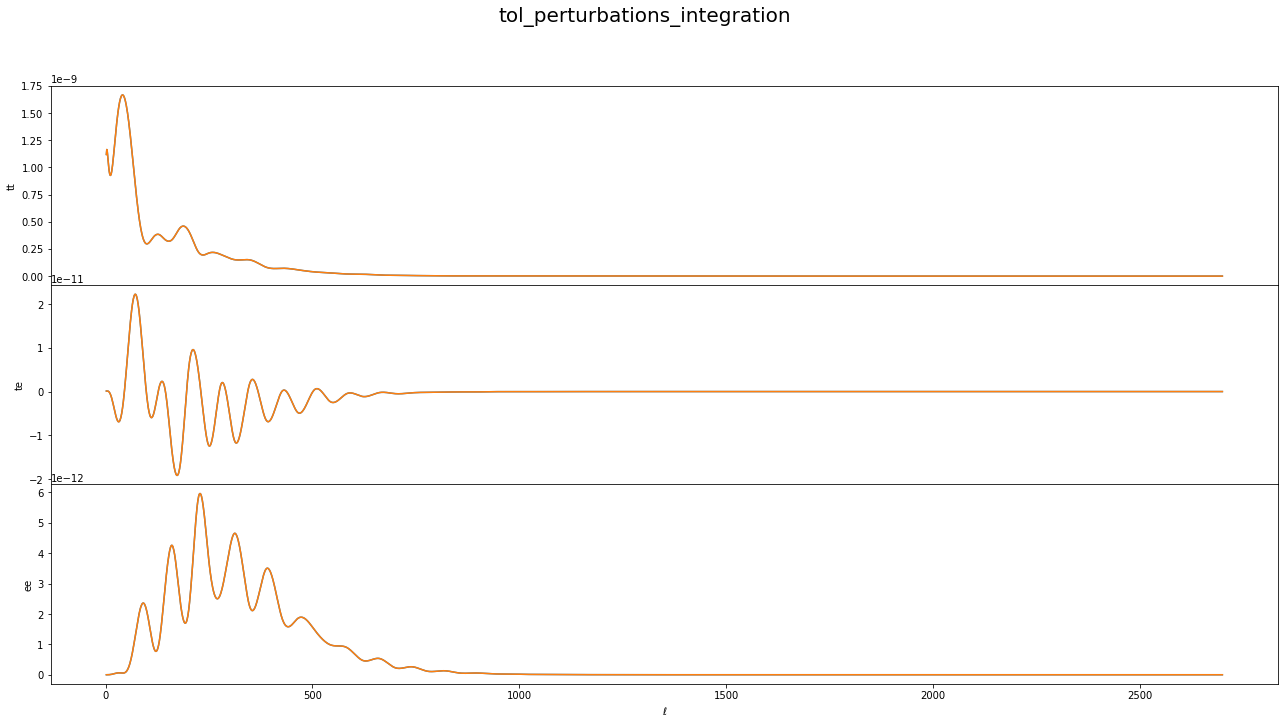

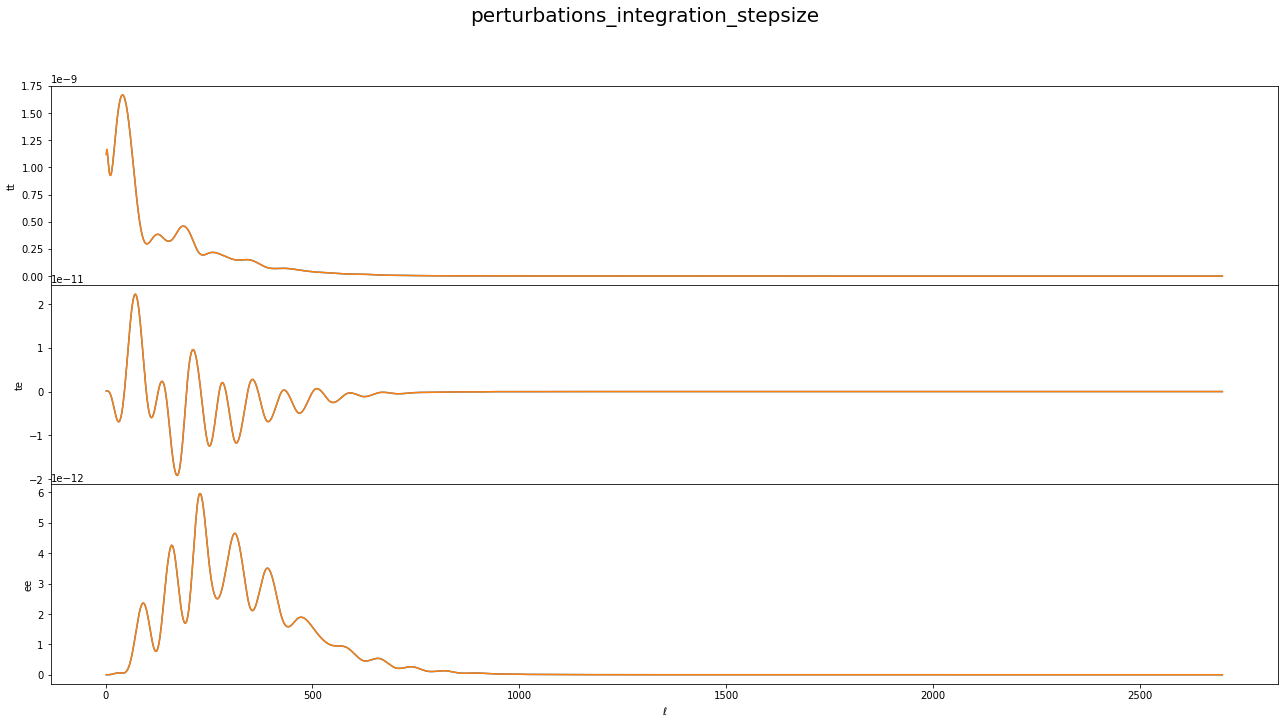

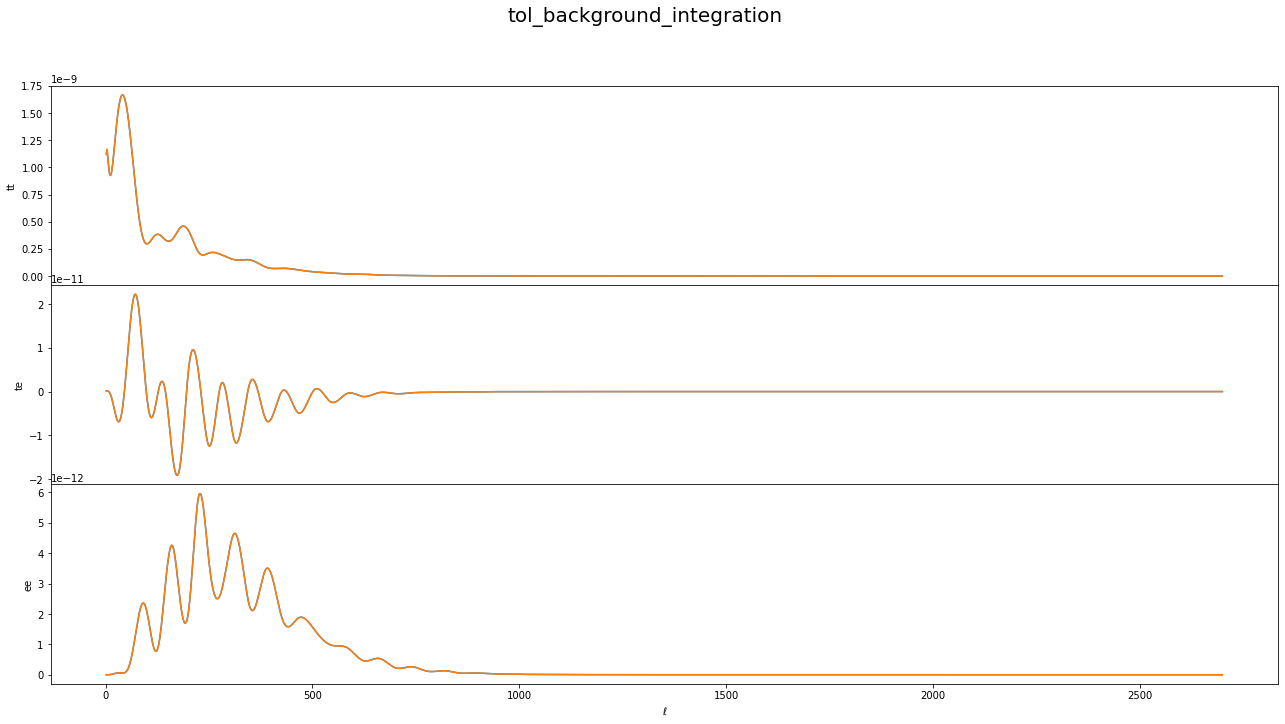

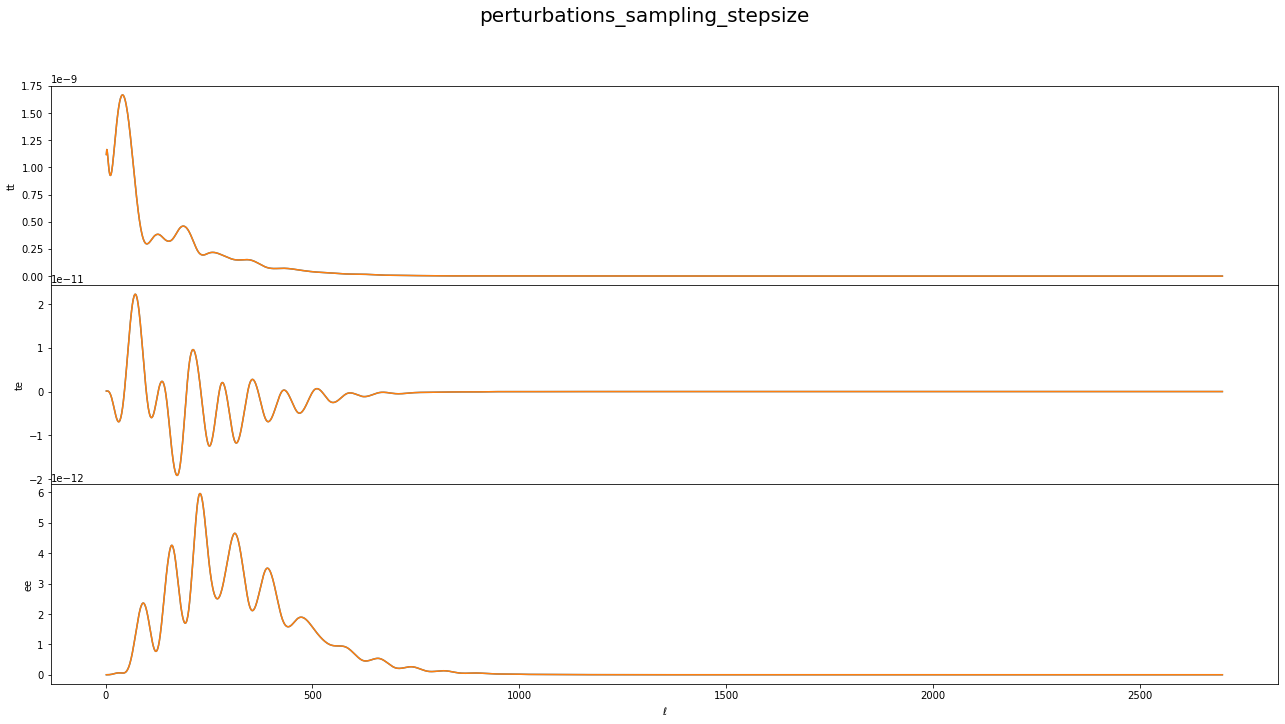

In [27]:
for key, cls in prec_cls.items():
    fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
    fig.subplots_adjust(hspace=0)
    fig.suptitle(key,  fontsize=20)
    plt.autoscale(

    )
    plt.xlabel(r'$\ell$')
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*bad_cls[0,mode_idx,:],label = mode)
        axs[mode_idx].plot(ells, ell_factor*cls[mode_idx,:],label = mode)
        axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
    plt.show()

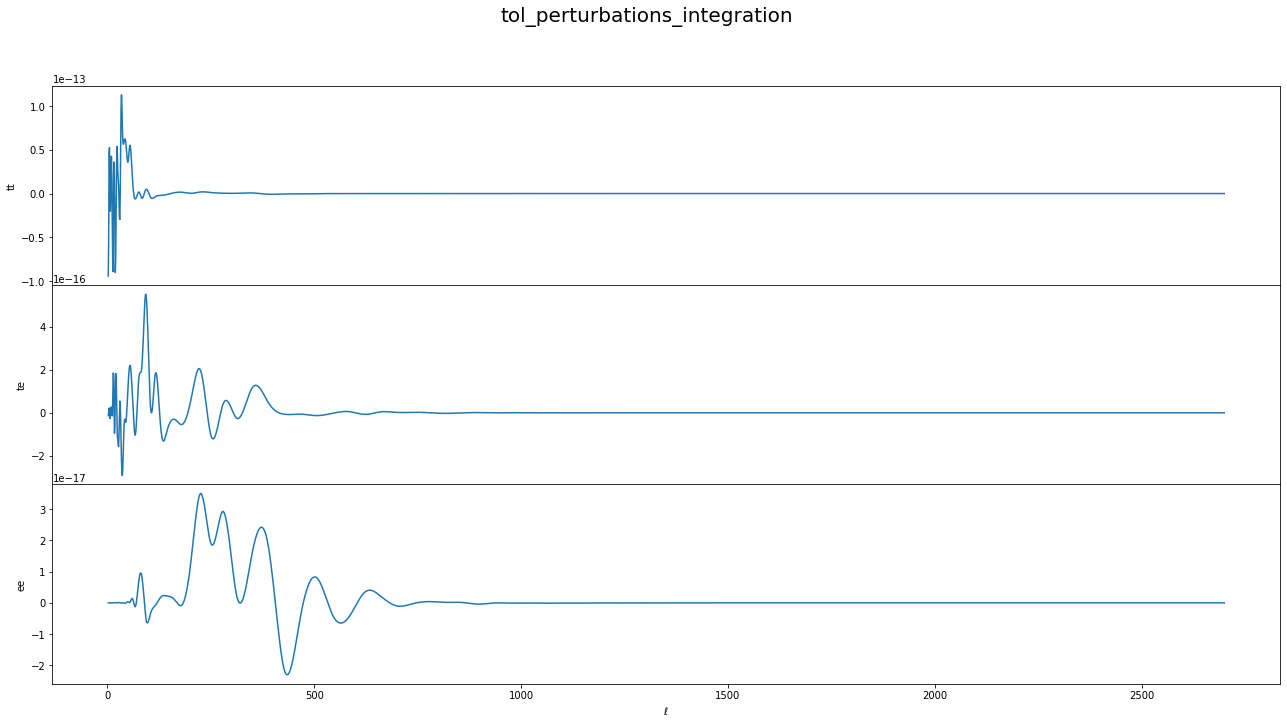

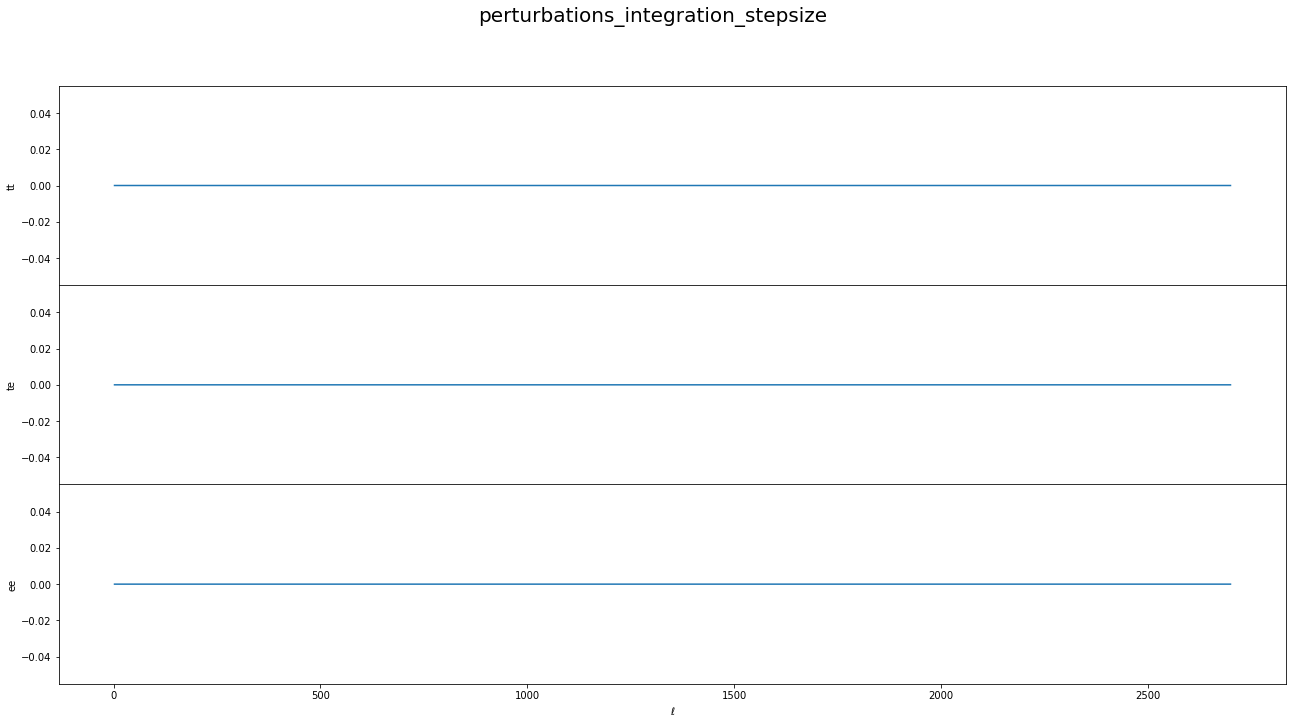

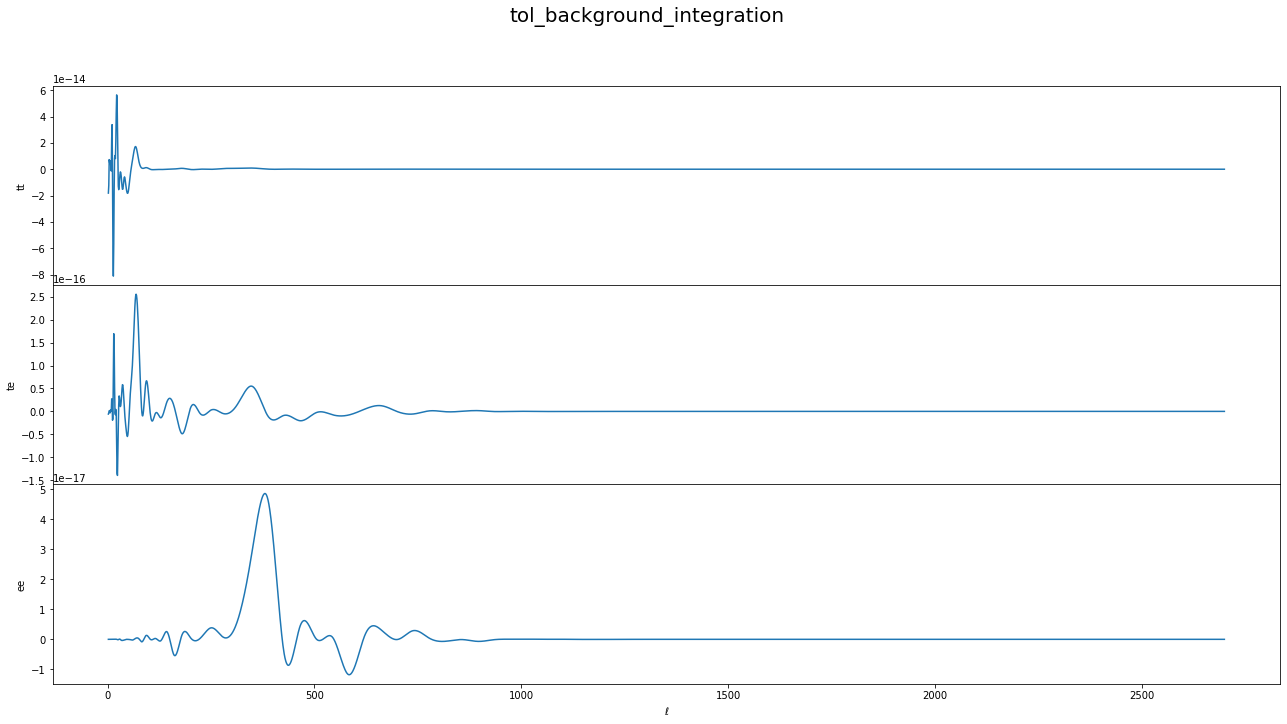

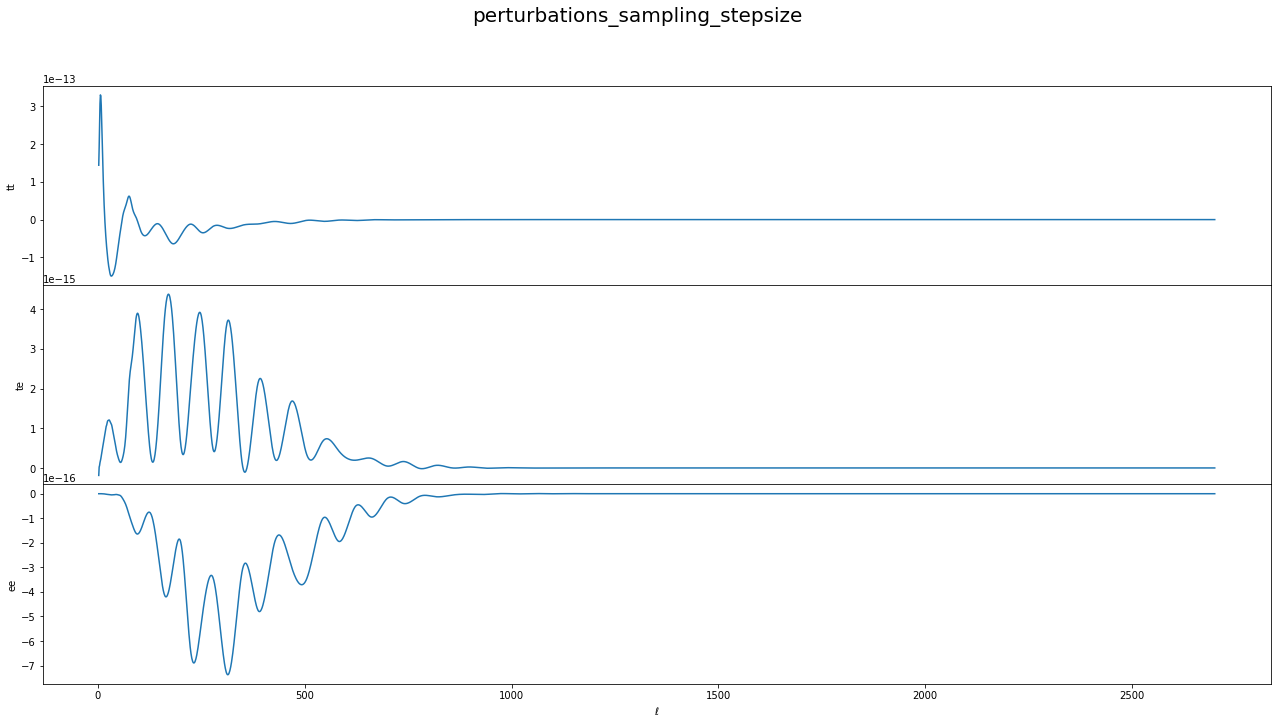

In [28]:
for key, cls in prec_cls.items():
    fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
    fig.subplots_adjust(hspace=0)
    fig.suptitle(key,  fontsize=20)
    plt.autoscale(

    )
    plt.xlabel(r'$\ell$')
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*(bad_cls[0,mode_idx,:]-cls[mode_idx,:]),label = mode)
        axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
    plt.show()

In [29]:


prec_a_sample_cls = {}

for pre_key, def_val in precision_options:
    cosmo.set({**mp.get_class_input(a_sample_param),
               **output_settings_DEF,
              pre_key:def_val/2.0})
    cosmo.compute()
    cls = cosmo.lensed_cl()
    prec_a_sample_cls[pre_key] = np.vstack(tuple(cls[k][l_min:l_max+1].astype(float) for k in ['tt', 'te', 'ee']))

    cosmo.struct_cleanup()
    cosmo.empty()

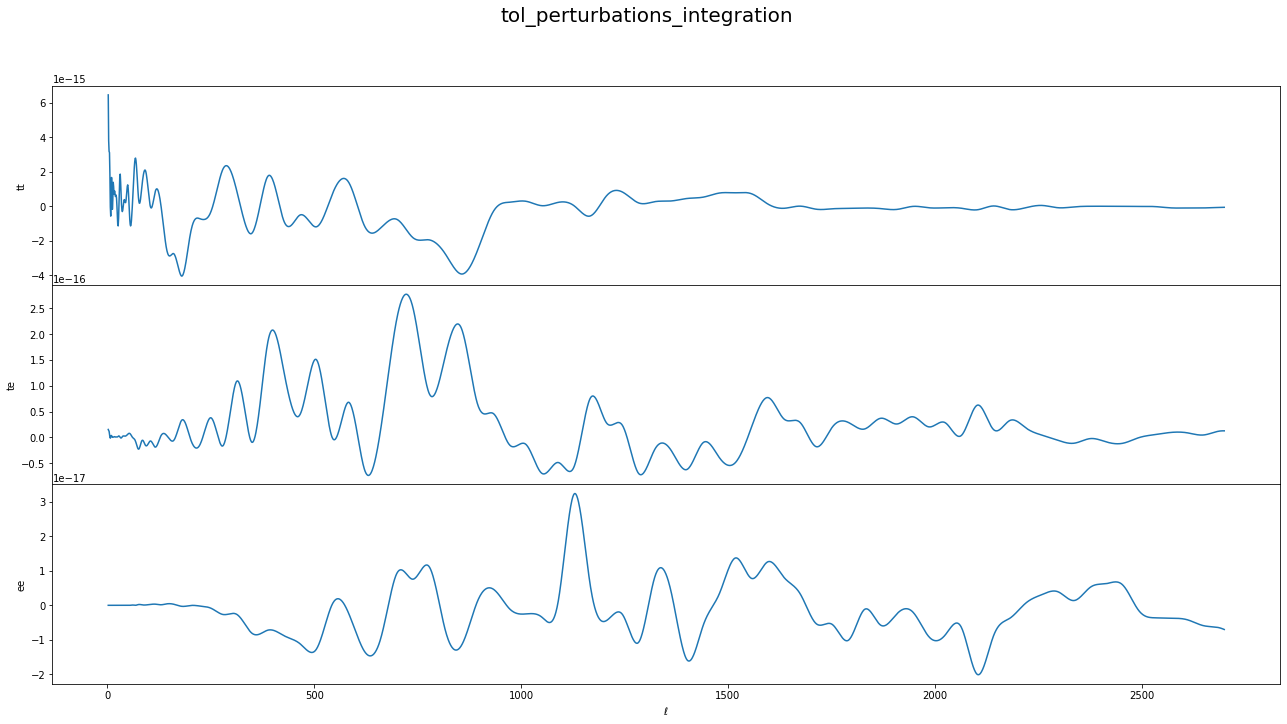

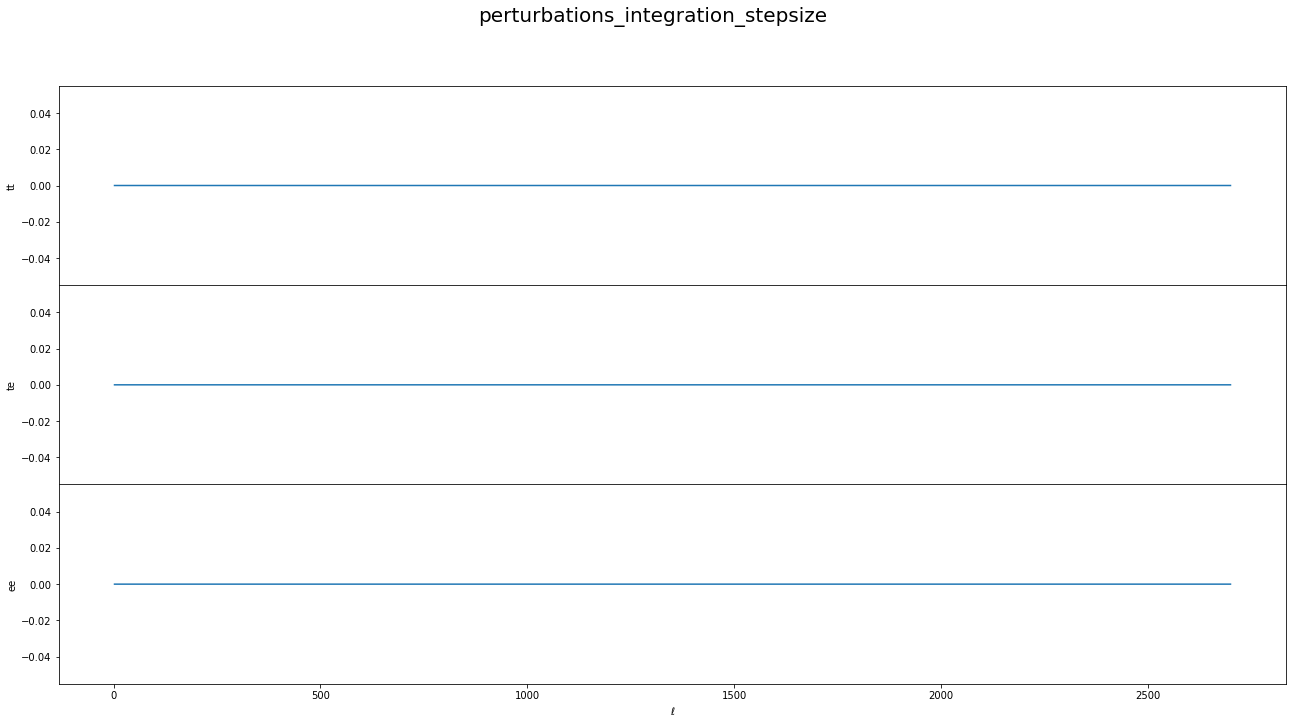

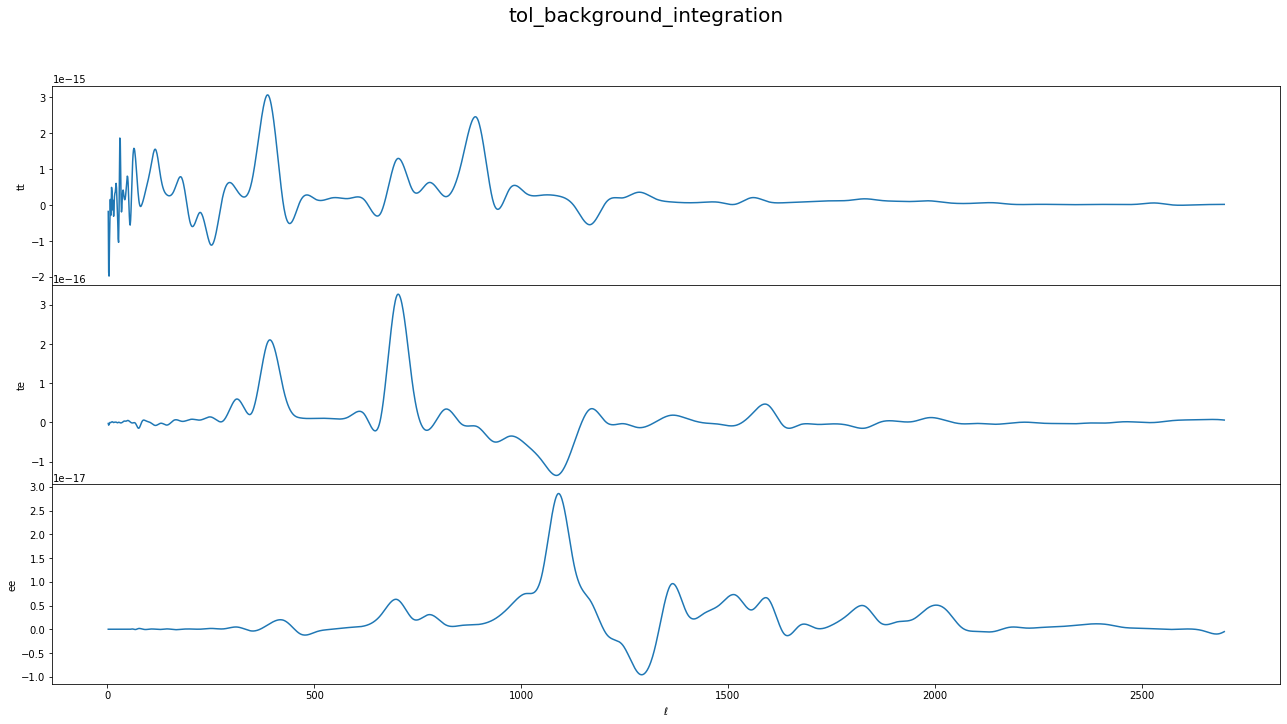

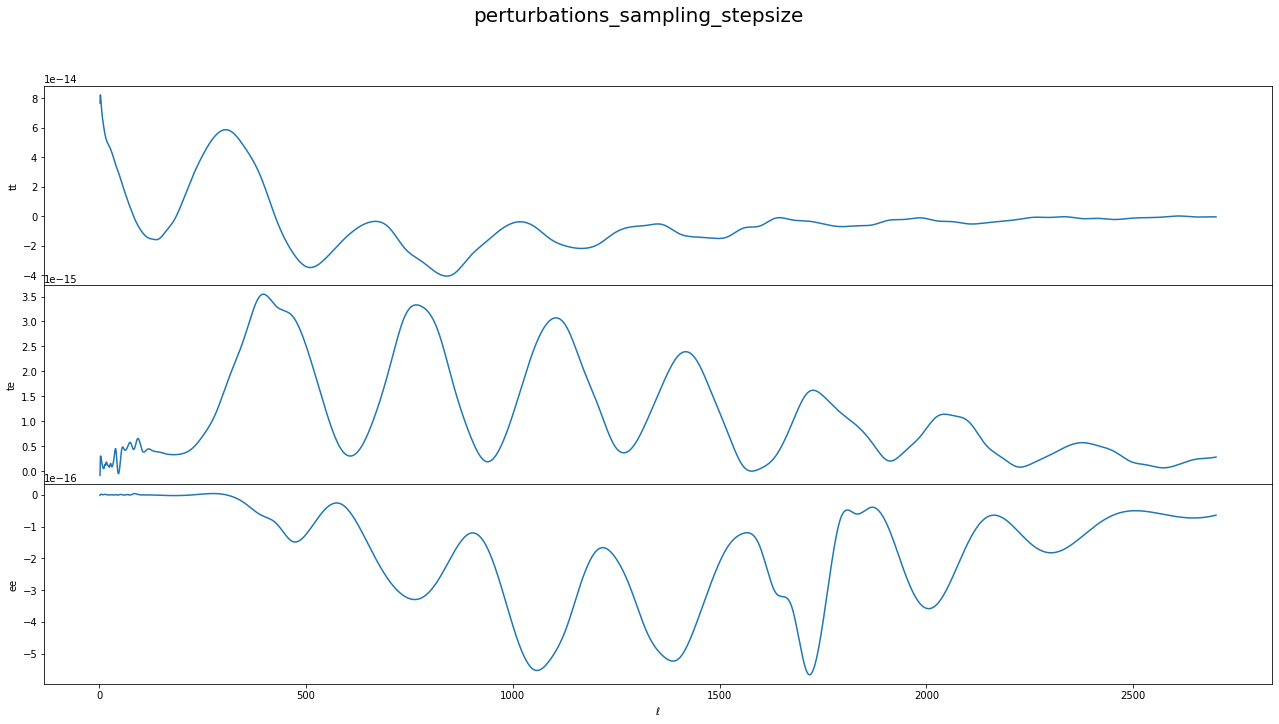

In [30]:
for key, cls in prec_a_sample_cls.items():
    fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
    fig.subplots_adjust(hspace=0)
    fig.suptitle(key,  fontsize=20)
    plt.autoscale(

    )
    plt.xlabel(r'$\ell$')
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*(a_cl_sample[mode_idx,:]-cls[mode_idx,:]),label = mode)
        axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
    plt.show()

In [35]:
prec_planck18_cls = {}

for pre_key, def_val in precision_options:
    cosmo.set({**mp.get_class_input(planck18_param),
               **output_settings_DEF,
              pre_key:def_val/2.0})
    cosmo.compute()
    cls = cosmo.lensed_cl()
    prec_planck18_cls[pre_key] = np.vstack(tuple(cls[k][l_min:l_max+1].astype(float) for k in ['tt', 'te', 'ee']))

    cosmo.struct_cleanup()
    cosmo.empty()

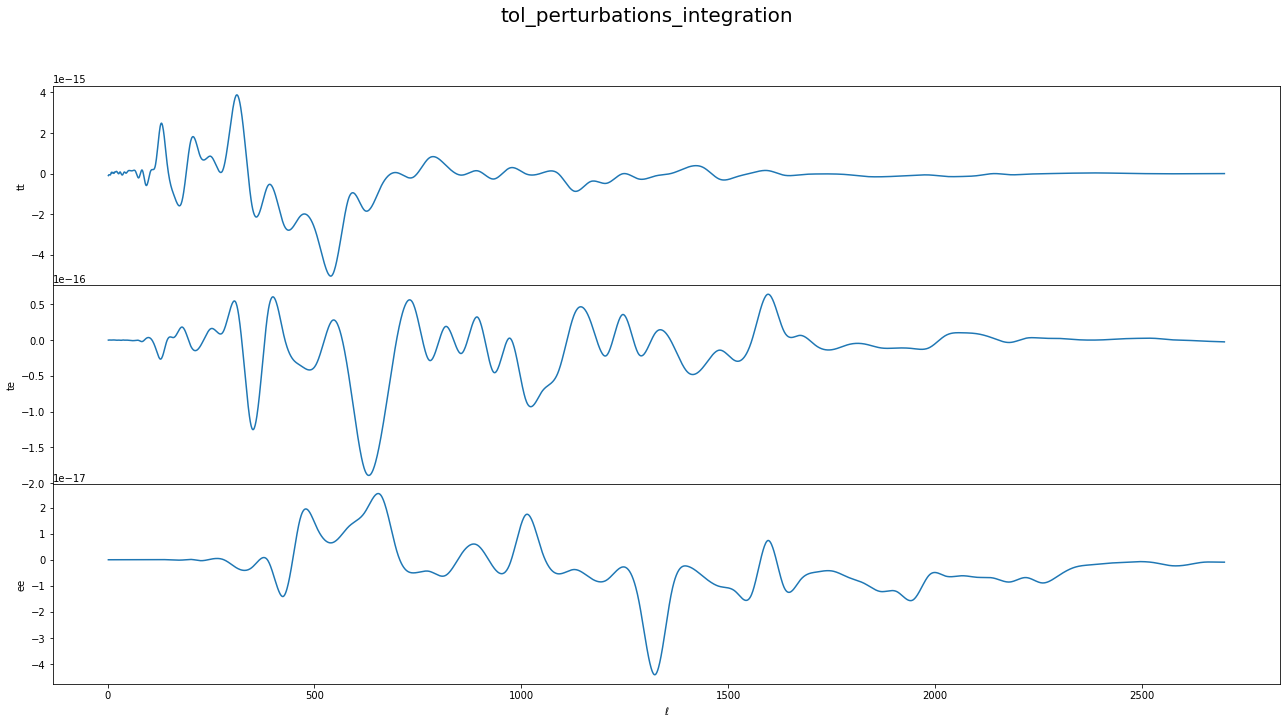

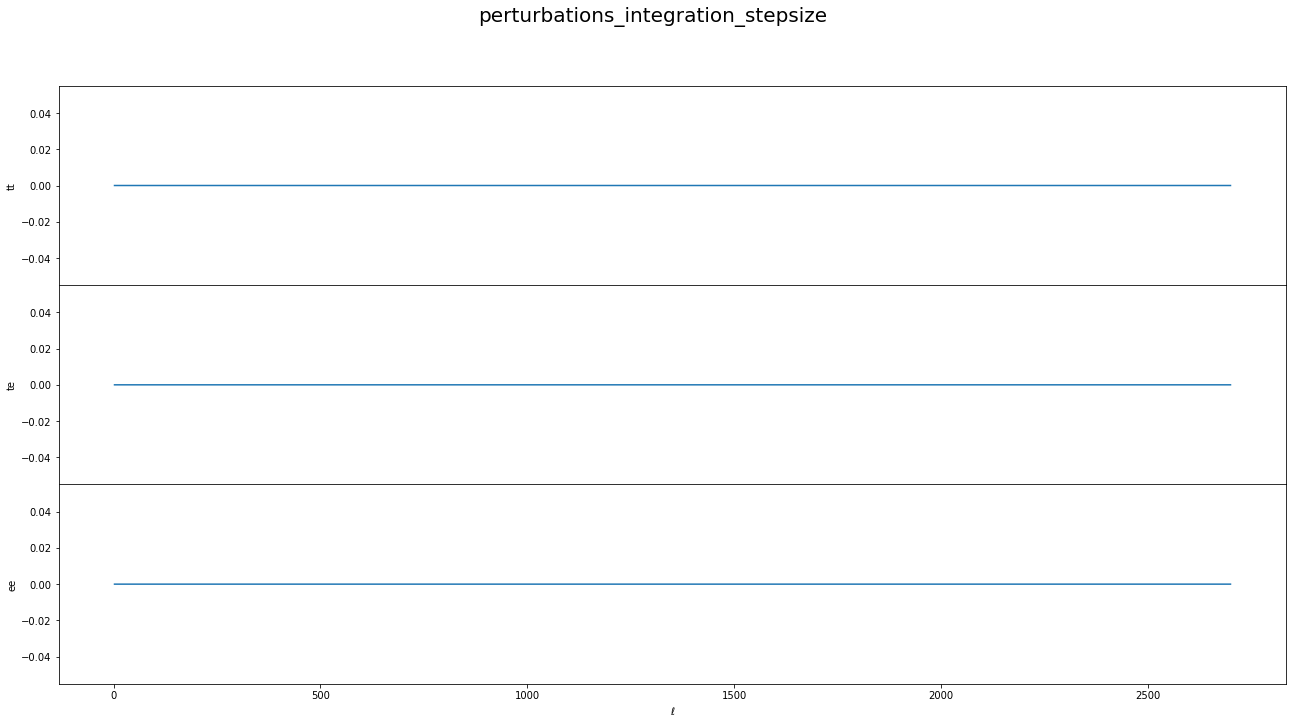

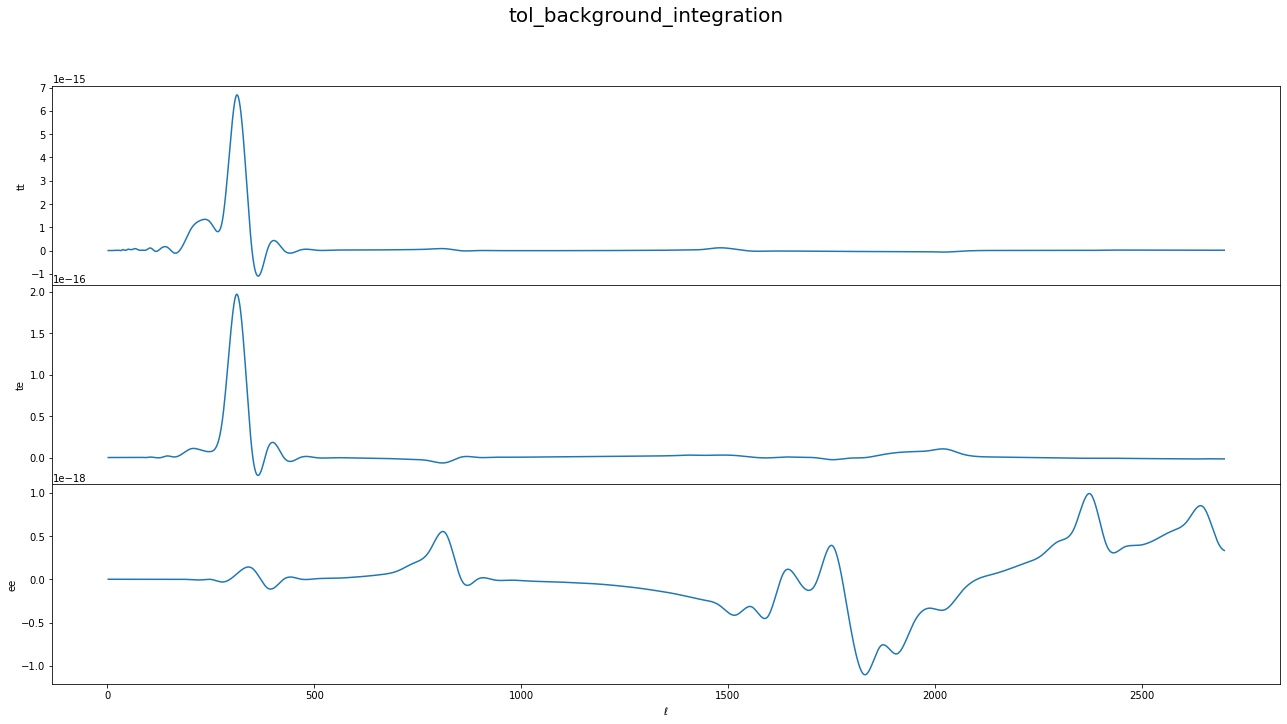

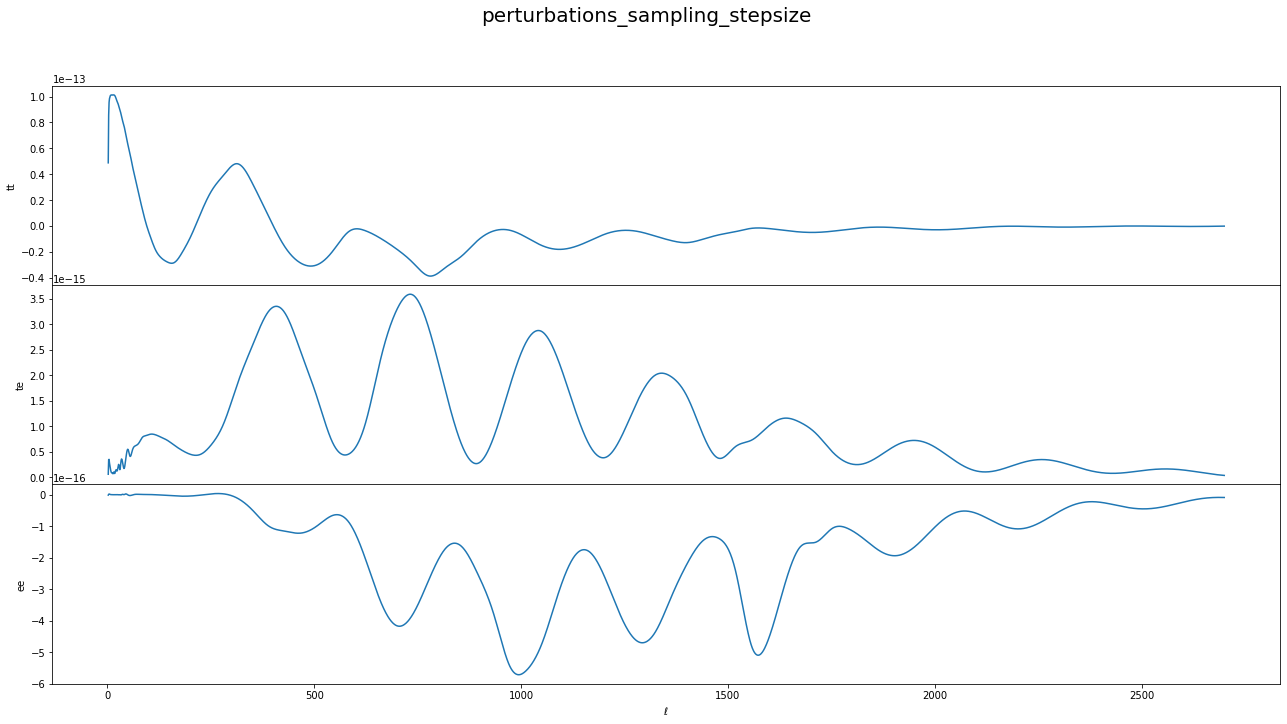

In [42]:
for key, cls in prec_planck18_cls.items():
    fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11))
    fig.subplots_adjust(hspace=0)
    fig.suptitle(key,  fontsize=20)
    plt.autoscale(

    )
    plt.xlabel(r'$\ell$')
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*(plank18_cls[mode_idx,:]-cls[mode_idx,:]),label = mode)
        axs[mode_idx].set_ylabel(['tt', 'te', 'ee'][mode_idx])
    plt.show()

In [46]:
copy_a_sample_params = copy.copy(a_sample_param)
copy_bad_sample_param = copy.copy(bad_params[0])
t_range = np.linspace(0, 1 , 6)
param_smear = tuple(copy_bad_sample_param *(1-t) +copy_a_sample_params*t for t in t_range)
smear_cls = []
for params in param_smear:
    smear_cls += [make_sample_cls(cosmo,params)]


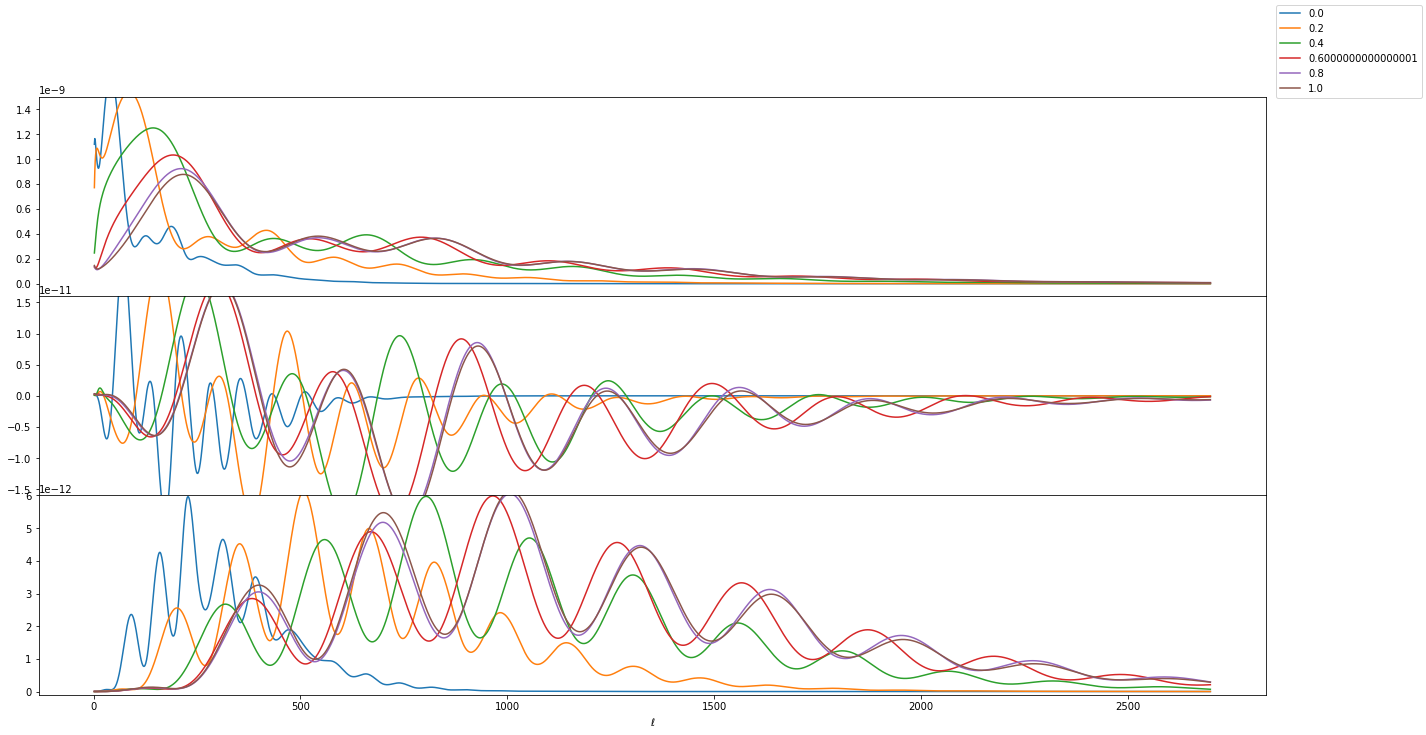

In [48]:
fig, axs = plt.subplots(3, sharex=True, figsize=(22, 11));
fig.subplots_adjust(hspace=0);
plt.xlabel(r'$\ell$')
for cls, alpha in zip(smear_cls,t_range):
    for mode_idx, mode in enumerate(['tt','te','ee']):
        axs[mode_idx].plot(ells, ell_factor*cls[mode_idx,:],label = alpha);
        axs[mode_idx].set_ylim(((-1e-10,1.5e-9),(-1.6e-11,1.6e-11),(-1e-13,6e-12))[mode_idx])
    
fig.legend(t_range);

In [51]:
0.1+0.2

0.30000000000000004